# Performance review of the electron-common-ipc

This is an attempt to organize performance metrics of the electron-common-ipc components into a single document for analysis and comparison.

In future it will be good to:

    1. Add more metrics to the performance document such as memory usage, IO, CPU utilization.
    2. Add automated script that will download the required version of the packages and run tests on them.
    3. Optimize to plotting experience to be more meaningful and descriptive.
    4. Optimize the versioning approach from v1, v2, v3 to a meaningful versions
    5. Reuse code cells
 
To install dependencies use `pip install pandas numpy --user`

In [46]:
import os
import subprocess
from matplotlib.container import BarContainer
import pandas

def run_project_script(script: str, script_env = dict()) -> str:
    cwd = os.path.abspath(os.path.join(os.getcwd(), '..'))
    env = os.environ.copy() | script_env
    env.pop('ELECTRON_RUN_AS_NODE', None)

    completed_process = subprocess.run(
        script, capture_output=True, shell=True, env=env, cwd=cwd)
    if completed_process.returncode == 0:
        return completed_process.stdout.decode('utf-8')

    error = completed_process.stderr.decode('utf-8')
    out = completed_process.stdout.decode('utf-8')
    raise RuntimeError(
        "'{0}' failed. Exit code: {1}.\n{2}\n{3}".format(script,
                                                         completed_process.returncode,
                                                         error,
                                                         out))


def scrap_performance_results(input: str, table: dict[str, dict[str, float]], errors: dict[list[float]], groups: list[str]):
    parts = input.splitlines()

    for line in parts:
        line = line.strip()
        for group in groups:
            if line.startswith(group):
                if group not in table:
                    table[group] = dict()
                if group not in errors:
                    errors[group] = list()

                test_name = line.partition(']')[2].split('|')[0].strip()
                test_metrics = line.split('|')[1].strip().split(' ')
                test_average_time = float(test_metrics[0])
                error_time = float(test_metrics[3])

                table[group][test_name] = test_average_time
                errors[group].append(error_time)


def plot_performance_bars(table: dict[str, float], errors: dict[str, list[str]], xlim: float):
    errors = list(map(lambda x: errors[x], errors))
    frame_values = list(map(lambda x: list(table[x].values()), table))
    data_frame = pandas.DataFrame(table)
    bars = data_frame.plot.barh(
        xerr=errors, figsize=(15, len(frame_values[0]) + 2))
    bars.set_xlim(0, xlim)

    index = 0
    for container in bars.containers:
        if isinstance(container, BarContainer):
            value_and_error = list(
                zip(frame_values[index], errors[index]))
            bars.bar_label(container, map(
                lambda x: '{0} ms (+/- {1} ms)'.format(x[0], x[1]), value_and_error))
            index += 1


## web-socket vs web-socket-browser

Average for `[1,2,3,4,5,6,"7"] | ws-node | echo_wait` is `55.43635599911213`ms
Average for `[1,2,3,4,5,6,"7"] | ws-node | to_dispatch` is `66.83623800307512`ms
Average for `[1,2,3,4,5,6,"7"] | ws-browser | echo_wait` is `43.53324401`ms
Average for `[1,2,3,4,5,6,"7"] | ws-browser | to_dispatch` is `57.660099979999984`ms


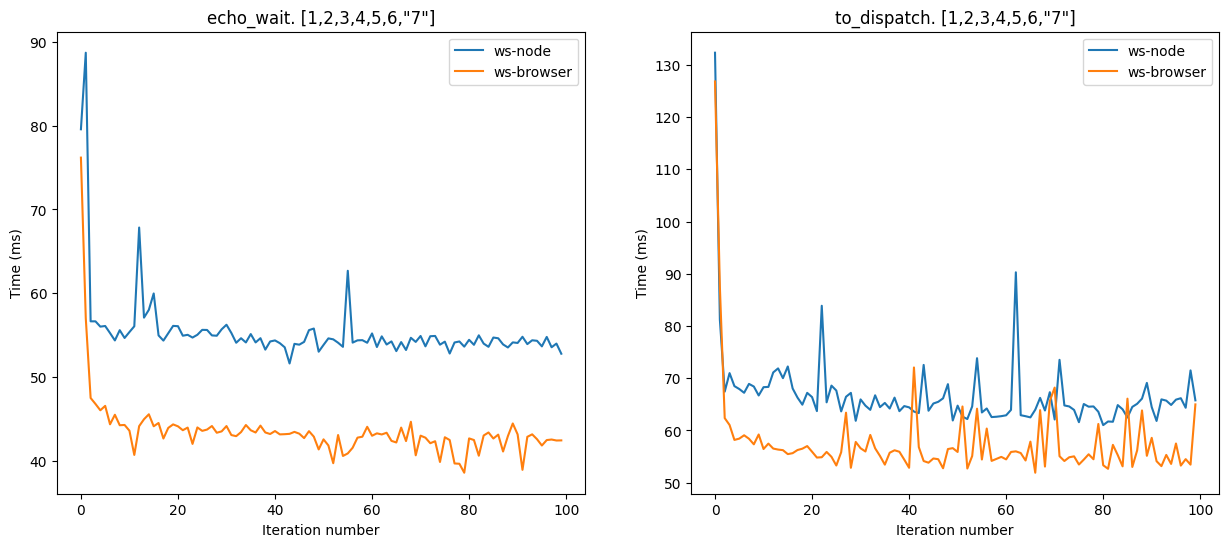

In [2]:
import itertools
import matplotlib.pyplot as plot
import numpy as np
import json

test_groups = dict()
test_files_compare = ['./perf-results/ws-node-v1.json',
                      './perf-results/ws-browser-v1.json']

# arrange data into groups
for test_index, test_compare in enumerate(test_files_compare):
    test_compare = json.load(open(test_compare))
    for index, value in enumerate(test_compare):
        curr_suite_name = value['name']
        curr_object_type = value['objectType']
        def key_func(x): return x['operation']
        sorted_its = sorted(value['iterations'], key=key_func)
        its_groups = itertools.groupby(sorted_its, key_func)

        if (curr_object_type not in test_groups):
            test_groups[curr_object_type] = dict()
        for perf_mark_name, op_results in its_groups:
            op_key = '{} | {} | {}'.format(
                curr_object_type, curr_suite_name, perf_mark_name)
            op_time = list(map(lambda x: x['time'], op_results))
            print('Average for `{}` is `{}`ms'.format(
                op_key, np.average(op_time)))

            if perf_mark_name not in test_groups[curr_object_type]:
                test_groups[curr_object_type][perf_mark_name] = []

            test_groups[curr_object_type][perf_mark_name].append(
                (curr_suite_name, op_time))

# plot the graphs
count_of_rows = len(test_groups.keys())
fig, plot_grid = plot.subplots(count_of_rows, 2, figsize=(15, 6))

for row_index, object_type in enumerate(test_groups):
    for index, perf_mark_name in enumerate(test_groups[object_type]):
        for (suite_name, op_time) in test_groups[object_type][perf_mark_name]:
            plot_grid[row_index].plot(np.arange(len(op_time)),
                                       op_time, label=suite_name)

        plot_grid[row_index].set_title('{}. {}'.format(perf_mark_name, object_type))
        plot_grid[row_index].set_xlabel('Iteration number')
        plot_grid[row_index].set_ylabel('Time (ms)')
        plot_grid[row_index].legend()
        row_index = row_index + 1


## web-socket-browser vs electron-common-ipc

#### Test the real case scenario within the Workspace, that sends function updates to the Excel

There are multiple processes involved during this test.
1) The original set of the processes that is used by the electron-common-ipc: Broker, Main(Bridge), Renderer(DataAPI), NodeJS(Shim)
2) The web socket connection uses 2 processes: Renderer(DataAPI), NodeJS(Shim)

For the function updates we use the service instance on Renderer(DataAPI) and proxy on NodeJS(Shim). We emulate the following communication within this library to compare performance results

### Big Object (~ 2 MB, 100 events)

#### Original serialization

In [14]:
output_v1_1 = run_project_script('npm run test:compare:rn', { "TEST_ITERATIONS": "5" })

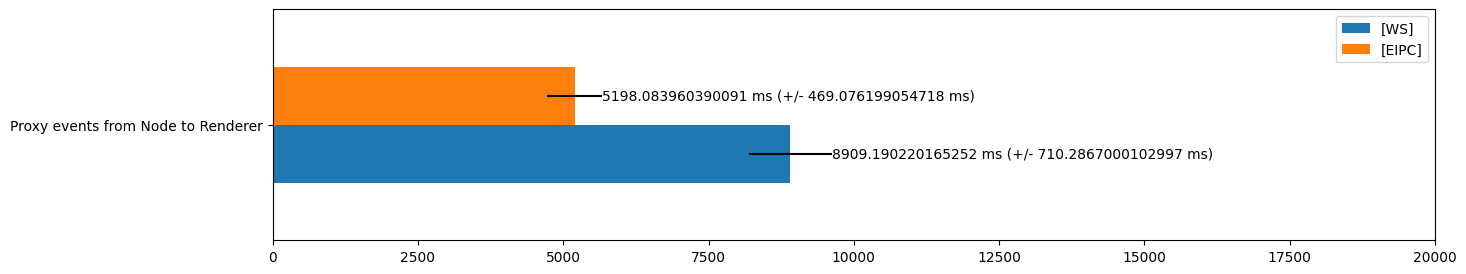

In [16]:
table, error = dict(), dict()
scrap_performance_results(output_v1_1, table, error, ['[WS]', '[EIPC]'])
plot_performance_bars(table, error, 20000)

#### Improved Buffer to String and String to Buffer serialization

In [ ]:
output_v2_1 = run_project_script('npm run test:compare:rn', { "TEST_ITERATIONS": "5" })

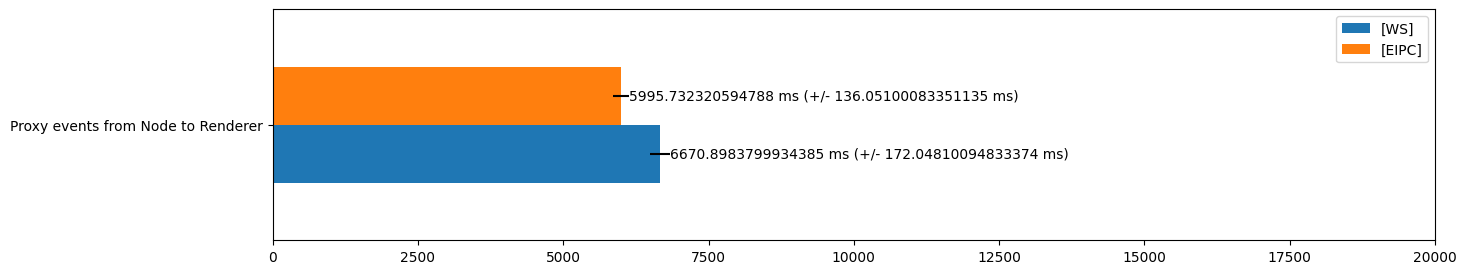

In [ ]:
table, error = dict(), dict()
scrap_performance_results(output_v2_1, table, error, ['[WS]', '[EIPC]'])
plot_performance_bars(table, error, 20000)

#### Improved String to Object and Object to String serialization

In [49]:
output_v3_1 = run_project_script('npm run test:compare:rn', { "TEST_ITERATIONS": "5" })

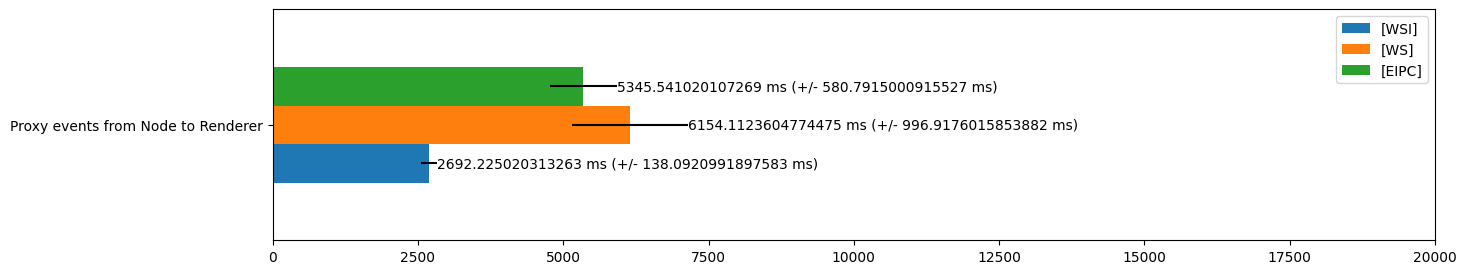

In [56]:
table, error = dict(), dict()
scrap_performance_results(output_v3_1, table, error, ['[WS]', '[WSI]', '[EIPC]'])
plot_performance_bars(table, error, 20000)

### Small Object (~ 50 bytes, 50000 events)

#### Original serialization - Stage 1

In [27]:
output_v1_2 = run_project_script('npm run test:compare:rn', {
    "TEST_ITERATIONS": "5",
    "TEST_OBJECT": '[1,3,2,{"formula":"RDP.Data","args":[1,2,3,4,5,6]}]',
    "NUMBER_OF_EVENTS": "50000"
})

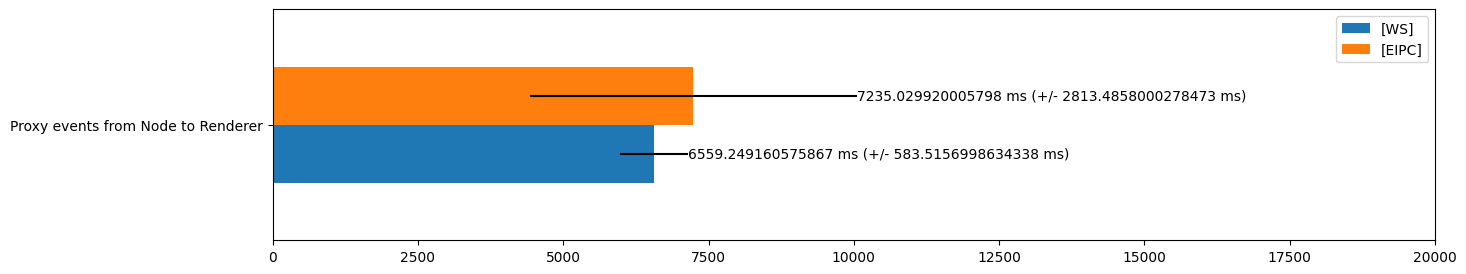

In [28]:
table, error = dict(), dict()
scrap_performance_results(output_v1_2, table, error, ['[WS]', '[EIPC]'])
plot_performance_bars(table, error, 20000)

#### Improved Buffer to String and String to Buffer serialization - Stage 2

In [39]:
output_v2_2 = run_project_script('npm run test:compare:rn', {
    "TEST_ITERATIONS": "5",
    "TEST_OBJECT": '[1,3,2,{"formula":"RDP.Data","args":[1,2,3,4,5,6]}]',
    "NUMBER_OF_EVENTS": "50000"
})

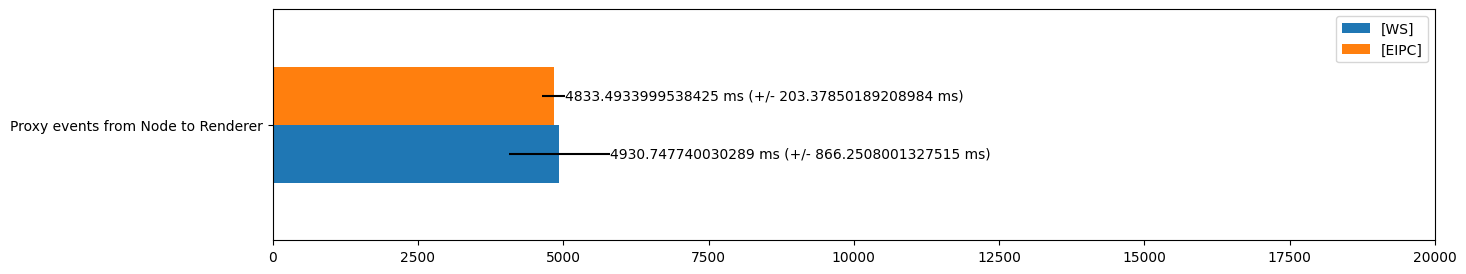

In [37]:
table, error = dict(), dict()
scrap_performance_results(output_v2_2, table, error, ['[WS]', '[EIPC]'])
plot_performance_bars(table, error, 20000)

#### Improved String to Object and Object to String serialization - Stage 3

In [63]:
output_v3_2 = run_project_script('npm run test:compare:rn', {
    "TEST_ITERATIONS": "5",
    "TEST_OBJECT": '[1,3,2,{"formula":"RDP.Data","args":[1,2,3,4,5,6]}]',
    "NUMBER_OF_EVENTS": "50000"
})

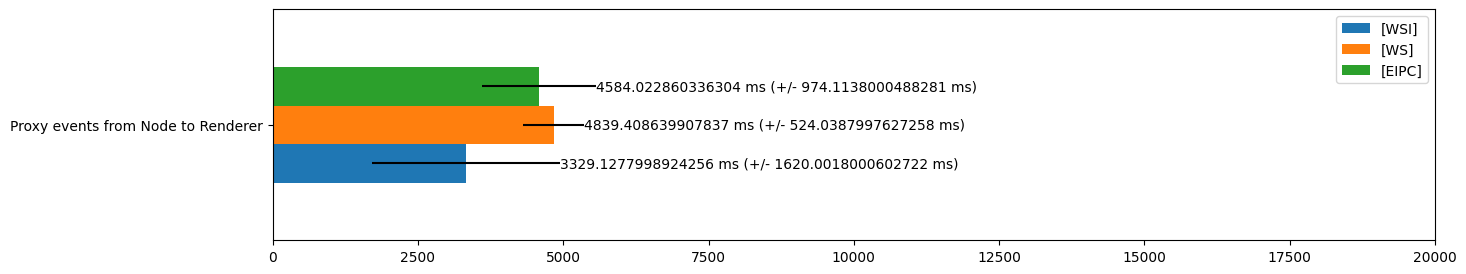

In [64]:
table, error = dict(), dict()
scrap_performance_results(output_v3_2, table, error, ['[WS]', '[WSI]', '[EIPC]'])
plot_performance_bars(table, error, 20000)